# **Search Algorithms**




# The Environment

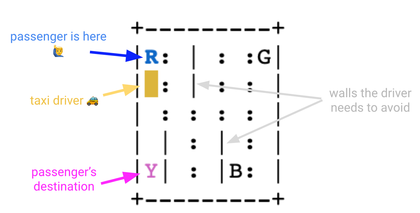




R, G, B, Y are locations on this map
The pipe symbol (|) represent walls
The colon symbol (:) represent open spaces

1.	The map is a 5x5 gridworld, leading to 25 locations.
2.	The alphabets R, G, B, Y are 4 locations.
3.	A passenger can be at any of the 4 locations.
4.	A passenger’s destination can be any of the left 3 locations.
5. The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.
6.	The taxi can pass through **:** but not **|**
7.	The colon symbol **:** denotes a pass, which means, |B:a| if you’re at position **a** you can get to position **B** by going left.
8.	The pipe symbol **|** denotes a wall, which means, |Y|x: if you’re at position **x** you can’t get to position **Y** by going left.
9.	The environment rewards 20 points when a passenger is dropped to their destination.
10.	The environment penalizes -10 points if pickup operation is performed on a cell where there is no passenger.
11.	The environment penalizes -10 points if drop operation is performed if no passenger had boarded the taxi.
12.	The environment penalizes -1 for every other action.
13.	There are 500 states in this environment.

Each state answers these questions:
1.	Where is the taxi right now (one out of the 25 cells).
2.	Where is the passenger right now (one out of R,G,B,Y and the possibility of being inside the taxi).
3.	Where does the passenger want to go (one out of R,G,B,Y).

Initial conditions:
1.	At the start, the taxi will be at any of the 25 positions on the map.
2.	A passenger will be at any of R, G, B, Y locations.
3.	A destination will be at any of the R, G, B, Y locations.

Agent — Taxi

Our agent is a taxi, which can perform 6 actions:
0.	South
1.	North
2.  West
3.	East
4.	Pickup
5.	Dropoff

Expected behaviour

1.	The taxi must find the passenger traveling the shortest path.
2.	The taxi must pickup the passenger.
3.	The taxi must find the shortest path to the passenger’s destination.
4.	Drop the passenger at their destination traversing the shortest path


**imports and useful libraries**

In [57]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.
from queue import Queue                  # Used in the implementation of BFS 
import heapq                             # Used in the implementation of A*

### **Initialize the environment and display the  initial state**

In [58]:
env = gym.make('Taxi-v3').env
state = env.reset()
env.unwrapped.s = 328
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [59]:
# Constants
UNLIMITED_DEPTH = -1
PASS_IN_TAXI = 4
GOAL = 20
PENALTY = -10
UCS_WEIGHT = 0
GREEDY_BEST_WEIGHT = 1

## **auxiliary functions and classes**

In [60]:
def print_frames(frames: list) -> None:
    """
    print_frames - print list of frames (path):
    arg:
      1. frames  - list of frames
    """
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        time.sleep(0.5)

In [61]:
class Node:
    """
    Node - node represent a state:
    arg:
       1. frame  - renderd frame of state
       2. state  - the actual state
       3. action - prev action 
       4. reward - prev action reward
       5. parent - prev node (state)
       6. depth  - depth of node (state)
    """
    def __init__(self, frame=None, state=None, action=None,
                 reward=0, parent=None, depth=0, g_val=0):
        self.frame = frame
        self.state = state
        self.action = action
        self.reward = reward
        self.parent = parent
        self.depth = depth
        self.g_val = g_val
    # for equal-break - useless
    def __lt__(self, other):
        return False

def getNeigbours(node: Node) -> list:
    """
    getNeigbours - returns sets of nodes we can reach from a given node:
    arg:
      1. node    - current node
    return:
       List of reachable nodes from current node
    """
    env.unwrapped.s = node.state
    neighbours = []
    for action in range(6):
        new_state, reward, done, info = env.step(action) # Take action i
        new_node = Node(env.render(mode='ansi'), new_state ,action,
                        reward, node, node.depth + 1)
        neighbours.append(new_node)
        env.unwrapped.s = node.state
    return neighbours

In [62]:
def get_path(node: Node) -> tuple:
    """
    get_path - returns the path of given node and reward:
    arg:
      1. node  - final node
    return:
       Tuple - (frames to final node, reward to final node)
    """
    total_reward = 0
    frames = []
    while node is not None:
        frames.append({
              'frame': node.frame,
              'state': node.state,
              'action': node.action,
              'reward': node.reward
              }
        )
        total_reward += node.reward
        node = node.parent

    return (frames[::-1], total_reward)

# **Breadth-First Search - BFS Algorithm (in Graph)**
- Comlete: yes, always find the a solution
- Optimal: yes, always find the best solution
- Time Complexity: O(b^s), when:
    1. b - branching factor
    2. s - tier of best the solution
    
- Space Complexity: O(b^s)


In [63]:
def bfs(first_state: int) -> tuple:
    """
    bfs - Breadth-First Search Algorithm:
    arg:
       1. first_state        - first state
    return:
       Tuple of (frames of optimal solution, reward of optimal solution)
    """
    # set environment to illustration's state
    env.unwrapped.s = first_state 
    # set of states weve visited in before
    visited = set()
    # queue of opened nodes 
    queue = Queue()
    opened_nodes = 0
    break_flag = False
  
    queue.put(Node(env.render(mode='ansi'), env.unwrapped.s, None, 0))
    visited.add(env.unwrapped.s)
    # will store final node
    final_node = None

    while queue.qsize() and not break_flag:
        curr_node = queue.get()
        opened_nodes += 1
        # if curr is final state
        if curr_node.reward == GOAL:
            final_node = curr_node
            break

        for neigbour in getNeigbours(curr_node):
            if neigbour.state not in visited:
                visited.add(neigbour.state)
                queue.put(neigbour)
            if neigbour.reward == GOAL:
                final_node = neigbour
                break_flag = True
                break

    # print("Number of opened nodes: {}".format(opened_nodes)) # = 31
    # Found Solution
    if final_node is not None:
        return get_path(final_node)

    # No Solution
    return ([], 0)


env.unwrapped.s = 328
frames,reward = bfs(env.unwrapped.s)
print_frames(frames)
print(reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 11
State: 0
Action: 5
Reward: 20
11


# **Limited Depth-First Search - DFS-L Algorithm (in Graph)**
- Comlete: no, solution might be deeper than *l*
- Optimal: no, optimal solution might be deeper than *l*
- Time Complexity: O(b^l), when:
    1. b - branching factor
    2. l - depth limitation
    
- Space Complexity: O(b*l) (in Tree)


In [64]:
def dfs_l(curr_node: Node, depth: int, visited: dict) -> tuple:
    """
    dfs_l - Limited Depth-First Search Algorithm:
    arg:
       1. curr_node     - current node
       2. depth         - depth limit
       3. visited       - visited set of nodes
    return:
       Tuple of (frames of solution, reward of solution), if found
    """
    # set environment to illustration's state
    env.unwrapped.s = curr_node.state

    if curr_node.reward == GOAL:
        return get_path(curr_node)

    neigbours = getNeigbours(curr_node)
    for neigbour in neigbours:
        if neigbour.reward == GOAL:
            return get_path(neigbour)

    for neigbour in neigbours:
        if (neigbour.state not in visited or (neigbour.depth < visited[neigbour.state].depth and depth != UNLIMITED_DEPTH) \
            or neigbour.reward == GOAL) and (depth == UNLIMITED_DEPTH or neigbour.depth <= depth):
            visited[neigbour.state] = neigbour
            frames, reward  = dfs_l(neigbour, depth, visited)
            if frames:
                return (frames, reward)
        

    # No Solution
    return ([], 0)

# **Depth-First Search - DFS Algorithm (in Graph)**
- Comlete: no, can be stuck in a loop
- Optimal: no, can be stuck in a loop
- Time Complexity: O(b^m), when:
    1. b - branching factor
    2. m - tier of first solution it sees ("leftmost") solution
    
- Space Complexity: O(b*m) (in Tree)


In [65]:
def dfs(first_state: int) -> tuple:
    """
    dfs - Depth-First Search Algorithm:
    arg:
       1. first_state   - first state
    return:
       Tuple of (frames of solution, reward of solution), if found
    """
    curr_node = Node(env.render(mode='ansi'), first_state, None, 0)

    # visited node set
    visited = dict()
    visited[first_state] = curr_node

    # use dfs-l without limitation of depth
    frames, reward = dfs_l(curr_node, UNLIMITED_DEPTH, visited)
    # print("Number of opened nodes: {}".format(len(visited))) # = 30
    return frames, reward



env.unwrapped.s = 328
frames,reward = dfs(env.unwrapped.s)
print_frames(frames)
print(reward)


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 19
State: 0
Action: 5
Reward: 20
3


# **Iterative Deepening Depth-First Search - ID-DFS Algorithm (in Tree)**
- Comlete: yes, always find the a solution
- Optimal: yes, always find the best solution
- Time Complexity: O(b^s), when:
    1. b - branching factor
    2. s - tier of best the solution
    
- Space Complexity: O(b*s)


In [66]:
def id_dfs(first_state: int, init_depth: int) -> tuple:
    """
    id_dfs - Iterative Deepening Depth-First Search Algorithm:
    arg:
       1. first_state   - first state
       2. init_depth    - initiale depth limit
    return:
       Tuple of (frames of optimal solution, reward of optimal solution)
    """
    # initial depth of search
    i = init_depth
    # search until solution found
    while True:
        curr_node = Node(env.render(mode='ansi'), first_state, None, 0)
        # visited node set
        visited = dict()
        visited[first_state] = curr_node
        
        # use dfs-l with depth limitation of i
        frames, reward = dfs_l(curr_node, i, visited)
        # print("Number of opened nodes: {}".format(len(visited))) # = 30

        # return a solution if found one
        if frames:
            return (frames, reward)
        # no solution in depth i - increase i
        i += 1


env.reset()
env.unwrapped.s = 328
initial_depth = 0
frames, reward = id_dfs(env.s, initial_depth)
#print_frames(frames)
#print(reward)

## **Comparison Between Different Initiale Depths - L in ID-DFS**

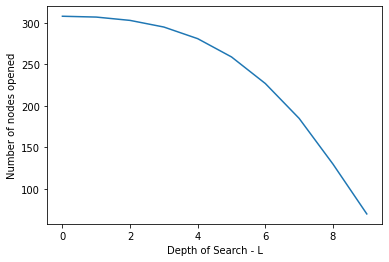

In [67]:
from matplotlib import pyplot as plt
import numpy as np


x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [308, 307, 303, 295, 281, 259, 227, 185, 130, 70]


#plt.plot(x , eval('np.power(3, x)'), label = "3^x")
plt.plot(x, y, label = "nodes opened")
plt.xlabel("Depth of Search - L")
plt.ylabel("Number of nodes opened")
plt.show()

# **Weighted-A* Search - W-A* Algorithm (in Tree)**
- Comlete: yes, always find the a solution
- Optimal: yes, always find the best solution
- Time Complexity: O(b^s), when:
    1. b - branching factor
    2. s - tier of best the solution
    
- Space Complexity: O(b*s)


In [68]:
def null_h(state: int) -> int:
    """
    Null Heuristic:
    arg:
        1. state - current state
    return: 0
    """
    return 0

def chosen_h(state: int) -> int:
    """
    Manhattan Sum Heuristic:
    arg:
        1. state - Current state
    return:
        h(s) = ManhattanDistance(s, loc_of_passenger) + ManhattanDistance(loc_of_passenger, loc_of_drop)
    """
    taxi_row, taxi_col, pass_idx, dest_idx = env.decode(state)
    if pass_idx == PASS_IN_TAXI:
        pass_row, pass_col = taxi_row, taxi_col
    else:
        pass_row, pass_col = env.locs[pass_idx]
    dest_row, dest_col = env.locs[dest_idx]
    return (abs(pass_row - taxi_row) + abs(pass_col - taxi_col)) + (abs(pass_row - dest_row) + abs(pass_col - dest_col))


def get_weight(weight: int, h_value: int, g_value: int) -> int:
    """
    get_weight - Calculate the f weight (priorety):
    arg:
      1. weight  - weight given to A*
      2. h_value - value given by the chosen heuristic
      3. g_value - accumulate value of the state
    return:
       f function: f(x) = (1-w)*g(n)+w*h(n)
    """
    return ((1 - weight) * g_value) + (weight * h_value)

def find_by_state(lst: list, state: int) -> tuple:
    """
    find_by_state - Search List/Queue to find state:
    arg:
       1. lst   - list/queue to search in
       2. state - state to find
    return:
       Tuple of (node of the state in the list, index of the state in the list)
    """
    index = 0
    for i in lst:
        if i[-1].state == state:
            return i[-1], index
        index += 1
        
    return None, None

In [69]:
def weighted_a_star(first_state: int, weight: int, heuristic_function) -> tuple:
    """
    weighted_a_star - Weighted-A* Search Algorithm:
    arg:
       1. first_state        - first state
       2. weight             - weight for f (priorety) calc
       3. heuristic_function - chosen heuristic
    return:
       Tuple of (frames of optimal solution, reward of optimal solution)
    """
    # set environment to illustration's state
    env.unwrapped.s = first_state 
    # priorety queue of nodes weve still working on - sorted by the f function
    open_list   = [(get_weight(weight, heuristic_function(first_state), 0), Node(env.render(mode='ansi'), env.unwrapped.s))]
    # dict of state: nodes weve visited in before
    closed_list = {}
    # will store the solution 
    final_node = None
    nodes_open = 0
    
    while open_list:
        nodes_open += 1
        # pop the best (lowest) valued node from the open nodes list (priorety queue)
        _, curr_node = heapq.heappop(open_list)
        closed_list[curr_node.state] = curr_node
        # were find the best path to the final state
        if curr_node.reward == GOAL:
            final_node = curr_node
            break
        
        for neigbour in getNeigbours(curr_node):
            # small optimization - wont count awful moves
            if neigbour.reward == PENALTY:
               continue              
            # new accumulate g value so far to neigbour
            new_g_value = curr_node.g_val + 1
            # if neigbour already in open list
            neigbour_in_open, index = find_by_state(open_list, neigbour.state)
            if neigbour_in_open is not None:
                if new_g_value < neigbour_in_open.g_val:
                    neigbour.g_val = new_g_value
                    del open_list[index]
                    heapq.heapify(open_list)
                    heapq.heappush(open_list ,(get_weight(weight, heuristic_function(neigbour.state), new_g_value), neigbour))
            
            # if neigbour already in closed list
            neigbour_in_closed = None
            try: 
                neigbour_in_closed = closed_list[neigbour.state]
            except KeyError:
                pass
            if neigbour_in_closed is not None:
                if new_g_value < neigbour_in_closed.g_val or \
                   neigbour_in_closed.reward != GOAL and neigbour.reward == GOAL:
                    neigbour.g_val = new_g_value
                    heapq.heappush(open_list, (get_weight(weight, heuristic_function(neigbour.state), new_g_value), neigbour))
                    del closed_list[neigbour.state]
            
            # if neigbour not in any of the lists
            if neigbour_in_closed is None and neigbour_in_open is None:
                neigbour.g_val = new_g_value
                heapq.heappush(open_list, (get_weight(weight, heuristic_function(neigbour.state), new_g_value), neigbour))

    # Found Solution
    #print(nodes_open)
    if final_node is not None:
        return get_path(final_node)

    # No Solution
    return ([], 0)

env.unwrapped.s = 328
weight = 0.5   
frames,reward = weighted_a_star(env.unwrapped.s,weight,chosen_h)
print_frames(frames)
print(reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 11
State: 0
Action: 5
Reward: 20
11


# W-A* - Compirason Between Different Weights

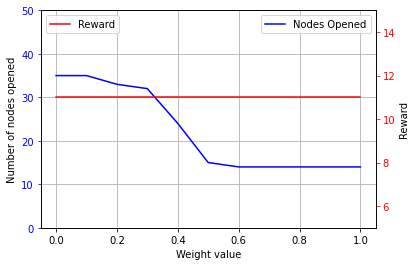

In [70]:
from matplotlib import pyplot as plt
import numpy as np

weights = [i/10 for i in range(11)]
rewards = []
nodes_opened = [35, 35, 33, 32, 24, 15, 14, 14, 14, 14, 14]

for w in weights:
    env.unwrapped.s = 328
    frames, reward = weighted_a_star(env.unwrapped.s, w, chosen_h)
    rewards.append(reward)

fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(weights, nodes_opened, '-b', label = 'Nodes Opened')
ax.tick_params(axis='y', colors='blue')
ax.legend(loc=0)
ax.grid()
ax.set_xlabel("Weight value")
ax.set_ylabel(r"Number of nodes opened")
ax.set_ylim(0,50)

ax2 = ax.twinx()
ax2.plot(weights, rewards, '-r', label = 'Reward')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylabel(r"Reward")
ax2.set_ylim(5, 15)
ax2.legend(loc=2)

plt.show()

# **Uniform Cost Search - UCS Algorithm (in Tree)**
- Comlete: yes, always find the a solution
- Optimal: yes, always find the best solution
- Time Complexity: O(b^s), when:
    1. b - branching factor
    2. s - tier of best the solution
    
- Space Complexity: O(b*s)


In [71]:
def ucs(first_state: int, heuristic_function) -> tuple:
    """
    ucs - Uniform Cost Search Search Algorithm:
    arg:
       1. first_state        - first state
       2. heuristic_function - chosen heuristic
    return:
       Tuple of (frames of optimal solution, reward of optimal solution)
    """
    return weighted_a_star(first_state, UCS_WEIGHT, heuristic_function)

env.unwrapped.s = 328  
frames,reward = ucs(env.unwrapped.s,chosen_h)
print_frames(frames)
print(reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 11
State: 0
Action: 5
Reward: 20
11


# **Greedy Best-First Search - G-BFS Algorithm (in Tree)**
- Comlete: yes (when the number of states is final)
- Optimal: no, depends only on heuristic function
- Time Complexity: O(b^s), when:
    1. b - branching factor
    2. s - tier of best the solution
    
- Space Complexity: O(b*s)


In [72]:
def g_bfs(first_state: int, heuristic_function) -> tuple:
    """
    g_bfs - Greedy Best-First Search Algorithm:
    arg:
       1. first_state        - first state
       2. heuristic_function - chosen heuristic
    return:
       Tuple of (frames of optimal solution, reward of optimal solution)
    """
    return weighted_a_star(first_state, GREEDY_BEST_WEIGHT, heuristic_function)

env.unwrapped.s = 328  
frames,reward = g_bfs(env.unwrapped.s,chosen_h)
print_frames(frames)
print(reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 11
State: 0
Action: 5
Reward: 20
11


# **A*-Epsilon Search - A*-ε Algorithm (in Tree)**
- Comlete: yes, always find the a solution
- Optimal: yes, always find the best solution
- Time Complexity: O(b^s), when:
    1. b - branching factor
    2. s - tier of best the solution
    
- Space Complexity: O(b*s)

In [116]:
def admissible_h(state):
    """
    Manhattan Sum Heuristic:
    arg:
        1. state - Current state
    return:
        h(s) = ManhattanDistance(s, loc_of_passenger) + ManhattanDistance(loc_of_passenger, loc_of_drop)
    """
    taxi_row, taxi_col, pass_idx, dest_idx = env.decode(state)
    if pass_idx == PASS_IN_TAXI:
        pass_row, pass_col = taxi_row, taxi_col
    else:
        pass_row, pass_col = env.locs[pass_idx]
    dest_row, dest_col = env.locs[dest_idx]
    return (abs(pass_row - taxi_row) + abs(pass_col - taxi_col)) + (abs(pass_row - dest_row) + abs(pass_col - dest_col))

def non_admissible_h(state):
    """
    Manhattan Sum Heuristic - Double delta:
    arg:
        1. state - Current state
    return:
        h(s) = ManhattanDistance(s, loc_of_passenger) + ManhattanDistance(loc_of_passenger, loc_of_drop)
    """
    taxi_row, taxi_col, pass_idx, dest_idx = env.decode(state)
    if pass_idx == PASS_IN_TAXI:
        pass_row, pass_col = taxi_row, taxi_col
    else:
        pass_row, pass_col = env.locs[pass_idx]
    dest_row, dest_col = env.locs[dest_idx]
    return (abs(pass_row - taxi_row) + abs(pass_col - taxi_col)*2) + (abs(pass_row - dest_row) + abs(pass_col - dest_col)*2)


In [117]:
def a_star_epsilon(first_state: int, weight: int, heuristic_function, epsilon: int) -> tuple:
    """
    a_star_epsilon - A*-Epsilon Search Algorithm:
    arg:
       1. first_state        - first state
       2. weight             - weight for f (priorety) calc
       3. heuristic_function - chosen heuristic
       4. epsilon            - chosen epsilon
    return:
       Tuple of (frames of optimal solution, reward of optimal solution)
    """
    # set environment to illustration's state
    env.unwrapped.s = first_state 
    # priorety queue of nodes weve still working on - sorted by the f function
    open_list   = [(get_weight(weight, heuristic_function(first_state), 0), Node(env.render(mode='ansi'), env.unwrapped.s))]
    # dict of state: nodes weve visited in before
    closed_list = {}
    # will store the solution 
    final_node = None
    opened_node = 0
    
    while open_list:
        opened_node += 1
        # pop the best (lowest) valued node from the open nodes list (priorety queue)
        min_f_open = open_list[0][0]
        focal = [item for item in open_list if item[0] <= min_f_open*(1 + epsilon)]
        item = min(focal, key=lambda t: heuristic_function(t[1].state))
        open_list.remove(item)
        heapq.heapify(open_list)

        curr_node = item[1]
        closed_list[curr_node.state] = curr_node

        # were find the best path to the final state
        if curr_node.reward == GOAL:
            final_node = curr_node
            break
        
        for neigbour in getNeigbours(curr_node):
            # small optimization - wont count awful moves
            if neigbour.reward == PENALTY:
               continue              
            # new accumulate g value so far to neigbour
            new_g_value = curr_node.g_val + 1
            # if neigbour already in open list
            neigbour_in_open, index = find_by_state(open_list, neigbour.state)
            if neigbour_in_open is not None:
                if new_g_value < neigbour_in_open.g_val:
                    neigbour.g_val = new_g_value
                    del open_list[index]
                    heapq.heapify(open_list)
                    heapq.heappush(open_list ,(get_weight(weight, heuristic_function(neigbour.state), new_g_value), neigbour))
            
            # if neigbour already in closed list
            neigbour_in_closed = None
            try: 
                neigbour_in_closed = closed_list[neigbour.state]
            except KeyError:
                pass
            if neigbour_in_closed is not None:
                if new_g_value < neigbour_in_closed.g_val or \
                   neigbour_in_closed.reward != GOAL and neigbour.reward == GOAL:
                    neigbour.g_val = new_g_value
                    heapq.heappush(open_list, (get_weight(weight, heuristic_function(neigbour.state), new_g_value), neigbour))
                    del closed_list[neigbour.state]
            
            # if neigbour not in any of the lists
            if neigbour_in_closed is None and neigbour_in_open is None:
                neigbour.g_val = new_g_value
                heapq.heappush(open_list, (get_weight(weight, heuristic_function(neigbour.state), new_g_value), neigbour))

    print(f"Number of opened nodes: {opened_node}")
    # Found Solution
    if final_node is not None:
        return get_path(final_node)

    # No Solution
    return ([], 0)


weight = 0.5   
epsilon = 0.5  

env.unwrapped.s = 328
frames,reward = a_star_epsilon(env.unwrapped.s,weight,admissible_h, epsilon)
#print_frames(frames)
print(reward)
env.unwrapped.s = 328
frames,reward = a_star_epsilon(env.unwrapped.s,weight,non_admissible_h, epsilon)
print(reward)

Number of opened nodes: 13
11
Number of opened nodes: 12
11


# Tests

In [ ]:
import signal

def signal_handler(signum, frame):
    raise Exception("timeout")

timeout = 5
signal.signal(signal.SIGALRM, signal_handler)
signal.alarm(timeout)

passed, failed = 0, 0
optimal_rewards = {}         

algorithm_names = ["BFS", "DFS", "ID-DFS", "W-A*"]
algorithm_func  = [bfs, dfs, id_dfs, weighted_a_star]
algorithm_args  = [[], [], [0], [0.5, chosen_h]]

def algo_wrapper(func, args: list) -> tuple:
    return func(*args)

print("*** START TESTS WITH TIMEOUT={}sec ***".format(timeout))

for algo in range(4):
    print("START {} TESTS:".format(algorithm_names[algo]))
    fail_flag = False
    for state in range(500):
        signal.alarm(timeout)
        try:
            env.unwrapped.s = state
            frames, reward = algo_wrapper(algorithm_func[algo], [state] + algorithm_args[algo])
            if frames == []:
                failed += 1
                fail_flag = True
                print("   {} TEST #{}: FAILED (empty list)".format(algorithm_names[algo], state))
            else:
                if algo == 0:
                    optimal_rewards[state] = reward
                    passed += 1
                elif (algo == 2 or algo == 3) and optimal_rewards[state] != reward:
                    failed += 1
                    fail_flag = True
                    print("   {} TEST #{}: FAILED (not optimal)".format(algorithm_names[algo], state))
                else:
                    passed += 1
        except Exception as e:
            failed += 1
            fail_flag = True
            print("   {} TEST #{}: FAILED ({})".format(algorithm_names[algo], state, e))
    if not fail_flag:
        print("   all {} - PASSED".format(algorithm_names[algo]))

print("PASS: {}, FAIL: {}".format(passed , failed))

*** START TESTS WITH TIMEOUT=5sec ***
START BFS TESTS:
   all BFS - PASSED
START DFS TESTS:
   all DFS - PASSED
START ID-DFS TESTS:
   all ID-DFS - PASSED
START W-A* TESTS:
   all W-A* - PASSED
PASS: 2000, FAIL: 0
